<a href="https://colab.research.google.com/github/LilShiro/BinaryEdgeImagesLCD/blob/master/BinEdgeMapsLCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Loop Detection using Binary Edge Images
### Done by: Zheng En Nicholas Goh 
### Supervised By: Prof. Paul Kelly, Riku Murai
Completed as part of Imperial MSc Computing Final Project.

## Overview
This code-base highlights how we use binary edge images to do loop closure detection. Binary edge images is a set of handcrafted image features as designed by Murai et al.[1] in their BIT-VO system, where a pixel containing a detected edge is given a value of 1 and 0 otherwise. By being able to execute reliable loop closure detection using such a reduced set of features, we are able to potentially extend the SLAM capabilities of the BIT-VO system, while continuing to exploit the low-powered and high frame rate of the BIT-VO. (See report.pdf for more details).

In [1]:
import os
# Importing necessary external python files
if not os.path.exists("functions.py"):
  !cp "drive/My Drive/Colab Notebooks/functions.py" .
if not os.path.exists("datasets.py"):
  !cp "drive/My Drive/Colab Notebooks/datasets.py" .
if not os.path.exists("vae.py"):
  !cp "drive/My Drive/Colab Notebooks/vae.py" .
if not os.path.exists("finalsampletrained.pth"):
  !cp "drive/My Drive/Colab Notebooks/finalsampletrained.pth" .
if not os.path.exists("edge_images_new"):
  !cp -r "drive/My Drive/Colab Notebooks/edge_images_new" .

In [2]:
# Importing of necessary libraries and functions
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.utils.data import DataLoader, ConcatDataset, random_split
from functions import *
from datasets import *
from vae import *

In [3]:
%%capture
# Importing of necessary train and test files
if not os.path.exists("deer_walk"):
  !wget https://www.doc.ic.ac.uk/~wl208/lmdata/deer_walk.zip
  !unzip deer_walk.zip
  !rm deer_walk.zip
if not os.path.exists("diamond_walk"):
  !wget https://www.doc.ic.ac.uk/~wl208/lmdata/diamond_walk.zip
  !unzip diamond_walk.zip
  !rm diamond_walk.zip
if not os.path.exists("new_college"):
  !wget http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/NewCollege/Images.zip
  !unzip Images.zip
  !mv Images new_college
  !rm Images.zip
  !wget http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/NewCollege/ImageCollectionCoordinates.txt
  !mv ImageCollectionCoordinates.txt new_college_GPS.txt
  !wget http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/NewCollege/masks/NewCollegeTextFormat.zip
  !unzip NewCollegeTextFormat.zip
  !rm NewCollegeTextFormat.zip
if not os.path.exists("city_center"):
  !wget http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/CityCentre/Images.zip
  !unzip Images.zip
  !mv Images city_center
  !rm Images.zip
  !wget http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/CityCentre/ImageCollectionCoordinates.txt
  !mv ImageCollectionCoordinates.txt city_center_GPS.txt
  !wget http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/CityCentre/masks/CityCentreTextFormat.zip
  !unzip CityCentreTextFormat.zip
  !rm CityCentreTextFormat.zip


## Binary Edge Images
Here we show an example of a set of binary edge images from RGB images with the usage of sobel filters and simple thresholding. Note that for our use case binary edge maps has been resized to (256, 256). Image sample is obtained from the deer-walk data set as designed by Saeedi et al.[4].

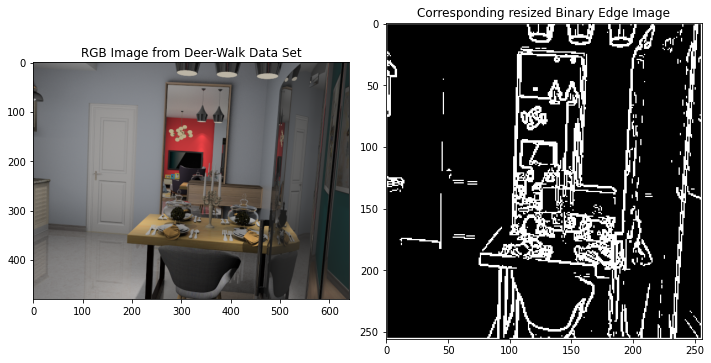

In [4]:
# setup data set and transformations for example
transformations = transforms.Compose([transforms.Grayscale(),
                                      getBinEdge((256, 256), 100), # inputs: (dimensions, threshold)
                                      transforms.ToTensor()])
data = Dataset("deer_walk/cam0/data", transform=transformations)
bin_edge, _, rgb_img = data[0]

# plot example
binexample = plt.figure(figsize = (10, 10))
rgbfig = binexample.add_subplot(1, 2, 1)
rgbfig.set_title('RGB Image from Deer-Walk Data Set')
plt.imshow(np.transpose(rgb_img, (1, 2, 0)))
binaryfig = binexample.add_subplot(1, 2, 2)
binaryfig.set_title('Corresponding resized Binary Edge Image')
plt.imshow(np.transpose(bin_edge, (1, 2, 0))[:,:,0], cmap='gray')
plt.tight_layout()

## Neural Network Training Process
Here we show an example of how training of our Neural Network is executed. More specifically, we train a Denoising Variational Auto-Encoder as implemented by Kingma et al.[2] where the inputs come in the form of 2D-Homography Deformations similar to those conducted by Merrill et al.[3]. Training of our neural network is done on synthetic images of indoor scenes i.e. deer-walk and diamond-walk data sets. as designed by Saeedi et al.[4].

In [5]:
# setting of neural network training hyperparameters and fields
threshold = 125 # edge thresholding
num_epochs = 1000
batch_size = 100
learning_rate = 1e-3
weight_dec = 1e-5
train_no = 2500 # number of data to train
beta = 1 # beta term for VAE
warmup = 500 # number of epochs for warmup
filetestname = 'SampleTrainedNN' # name for savefile for training data
device = torch.device('cuda:0') # GPU device


Training here is done on both the deer-walk and diamond-walk synthetic datasets specified above. Additional datasets should be setup should the user want to use a different training dataset.

In [6]:
# setting up of synthetic data sets for binary edge map conversion
transformations = transforms.Compose([transforms.Grayscale(),
                                      getBinEdge((256, 256), threshold),
                                      transforms.ToTensor()])
deer = Dataset("deer_walk/cam0/data", transform=transformations)
diamond = Dataset("diamond_walk/cam0/data", transform=transformations)
full_data = ConcatDataset((deer, diamond))
print('Total Number of Images: ', len(full_data))

Total Number of Images:  2563


Here we set up a corresponding intermediate binary edge map data set so as to speed up the transformation step when we train the neural network (i.e. instead of repeating binary edge map conversions at every sample.) Since the transformation from an RGB to binary edge map is static, pre-processing the train data and accessing this saved data is sufficient for our use-case.

In [7]:
# setting up intermediate binary edge maps data set
transform_loader = DataLoader(full_data,
                              batch_size=1,
                              shuffle=False)
for i, data in enumerate(transform_loader):
  img, _, _ = data
  if not os.path.exists("full_train_data"):
    !mkdir "full_train_data"
  save_image(img.double(), 'full_train_data/' + str(i).zfill(5) + '.png')

Finally, we setup this intermediate data-set and perform training for the neural network as seen below.

In [ ]:
# setting up of data set
data = Dataset("full_train_data", transform = transforms.Compose([transforms.Grayscale(),
                                                                  transforms.ToTensor()]))
train_data, _ = random_split(data, [train_no, len(data) - train_no])
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=8)

# training of neural network
vae = VAE()
vae.train()
vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_dec)
temp_beta = 0
for epoch in range(num_epochs):
    # beta warmup
    if temp_beta >= beta:
        temp_beta = beta
    else:
        temp_beta = (epoch / warmup) * beta
    train_loss = 0
    for data in train_loader:
        img, _, _ = data
        # add random homography deformations for 2D images
        img_corrupt = addNoise(img)
        img = img.to(device)
        img_corrupt = img_corrupt.to(device)
        reconstructed, mu, logvar, _, _ = vae(img_corrupt.float())
        loss = loss_func(reconstructed.float(), img.float(), mu, logvar, temp_beta)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)
    print('Epoch:{}, Average Item Loss:{:.4f}'.format(epoch + 1, float(train_loss)))

# save train file after complete
torch.save(vae.state_dict(), filetestname + '.pth')


## Determining Loop Closures
Here we conduct the actual loop closure detection. We detect loop closures in sequences rather than using individual image correspondence. We eliminate false positives largely through the rank reduction technique coupled with the adjusted Smith-Waterman algorithm as implemented in Ho et al.[5]. Testing here uses the a pre-trained neural network trained exclusively on the synthetic indoor data sets above - we do so to show the generalised performance of our algorithm on alternative data sets despite not training on these alternate data sets.

In [9]:
%%capture
# Load Save File and Neural Network
device = torch.device('cuda:0') # GPU device
vae = VAE()
vae.load_state_dict(torch.load('finalsampletrained.pth'))
vae.to(device)
vae.eval()

###New College Data Set
We first test on the New College Data Set[6]. This is a set of RGB images of real-life outdoor scenes. We will only use a subset of data corresponding to those taken with the left-view camera of the robot since including both left and right views simultaneously will cause a disruption when we are identifying sequences through the adjusted Smith-Waterman Algorithm.

In [10]:
# Parameters
threshold = 100 # edge thresholding
datatype = "newcollege"
leftright = 'left' # choice of camera view
interval = 1 # interval between input test images (i.e. Interval of 2 captures all alternate left view images)
batch_size = 100
reductionvalue = 7 # rank reduction degree
img_apart = 50 # number of frames between loop closure pairs
delta = 0.5 # penalty for one-to-many frames
min_seq_sim = 3.5 # total sequence similarity threshold
min_sim = 0.23 # minimum individual similarity threshold


In [11]:
# Setting up of Test Data Set
transformations = transforms.Compose([transforms.Grayscale(),
                                      getBinEdge((256, 256), threshold),
                                      transforms.ToTensor()])
test_data = realscenes("new_college", leftright, interval, transform=transformations)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=False)
# Executing Neural Network Compression Phase
full_latent = np.empty((1, 4096), int)
full_label = []
test_loss = 0
with torch.no_grad():
    for data in test_loader:
      img, label = data
      img, label = img.to(device), list(label)
      prediction, mu, logvar, _, features = vae(img.float())
      loss = loss_func(prediction.float(), img.float(), mu, logvar, 1)
      test_loss += loss.item()
      full_latent = np.append(full_latent, features[4].view(-1, 4096).cpu(), axis=0)
      full_label.extend(label)
full_latent = np.delete(full_latent, 0, axis=0)
test_loss /= len(test_loader.dataset)
print("Average Item Loss: ", test_loss)

# Executing Loop Closure Phases
sim_matrix = calc_sim(full_latent)
rankreduced_matrix = rankreduction(sim_matrix, reductionvalue, img_apart)
smith_water_matrix, min_tracker_full, max_tracker_full = full_smith_water(rankreduced_matrix, delta, min_seq_sim, min_sim, img_apart)
final_prediction = rankreduced_matrix * smith_water_matrix

Average Item Loss:  3306.520663443616


We print the similarity matrices and compare them against the truth matrix at various stages here. As we can see, we were able to identify all unique loop closure sequence in the Smith-Waterman Matrix.

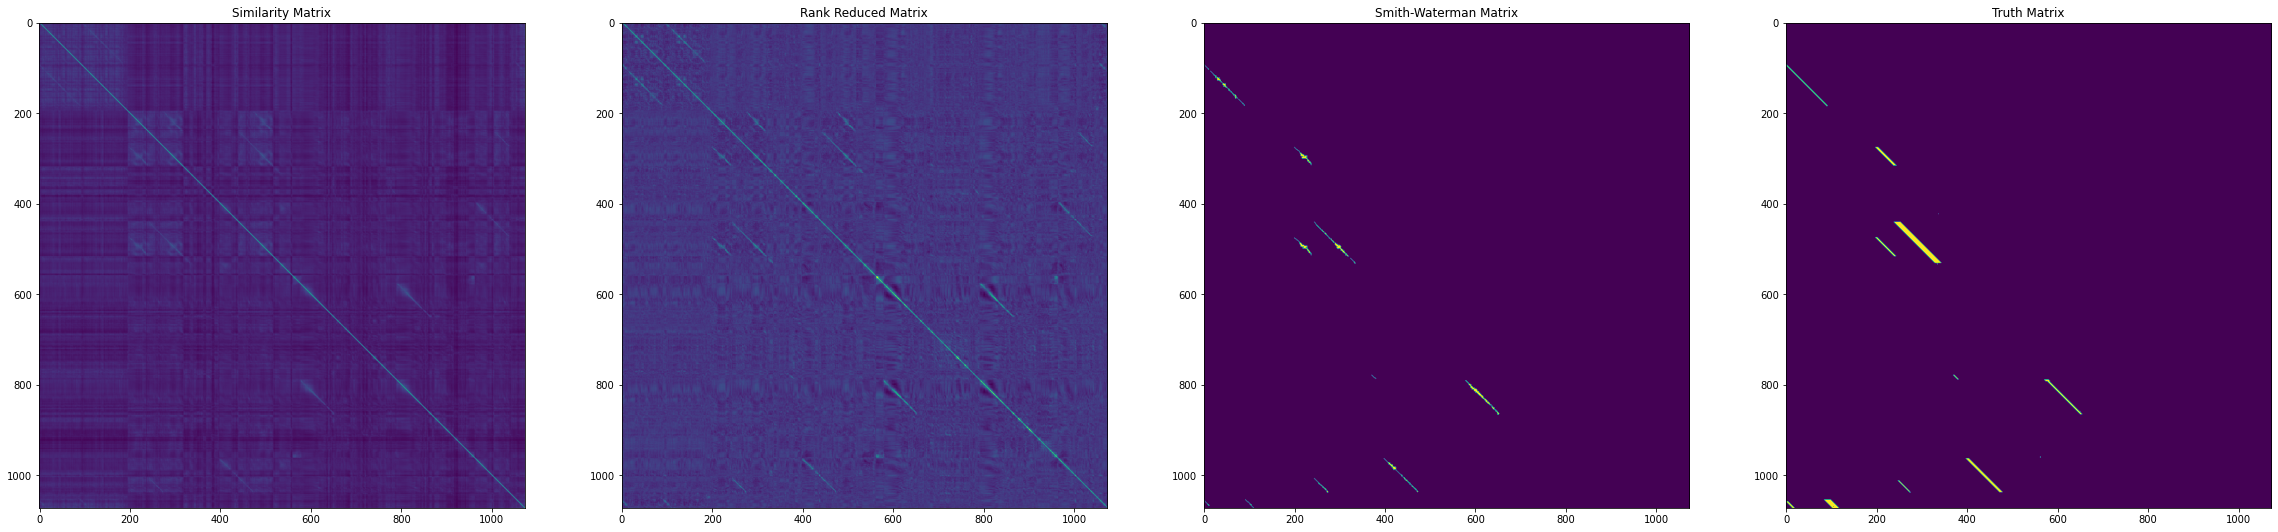

In [12]:
truth_matrix = np.genfromtxt("NewCollegeTextFormat.txt", delimiter=',', dtype=int)[::interval * 2, ::interval * 2]
printmat([sim_matrix, rankreduced_matrix, smith_water_matrix, truth_matrix], ["Similarity Matrix", "Rank Reduced Matrix", "Smith-Waterman Matrix", "Truth Matrix"], (40, 10))

This is verified by plotting the loop closure on the approximate movement map given the GPS coordinates of the robot. As we can see, all of the areas with loop closures were identified by our algorithm.

The main difference is that our predicted loop closures occurs with a lower density. This is because of the lack of one-to-many matching as seen from the thin diagonal lines in the Smith-Waterman Matrix versus the thicker ones within the truth matrix.

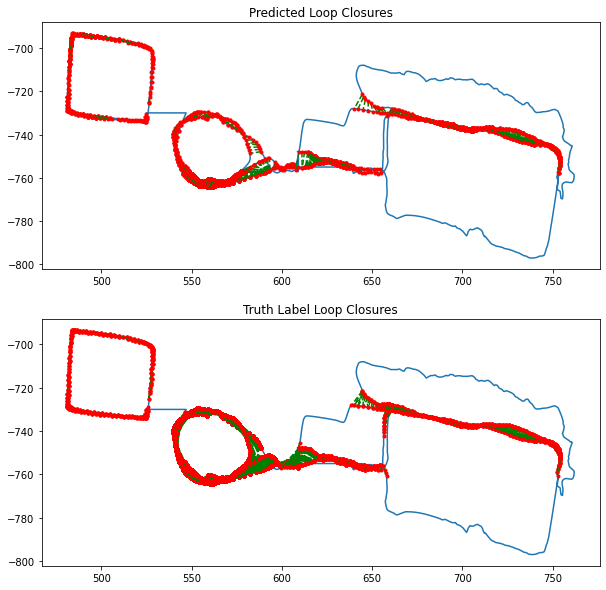

In [13]:
plotmovement(smith_water_matrix, datatype, full_label, (10, 10))

Here we print a subset of the strongest sequence that was identified by the algorithm.

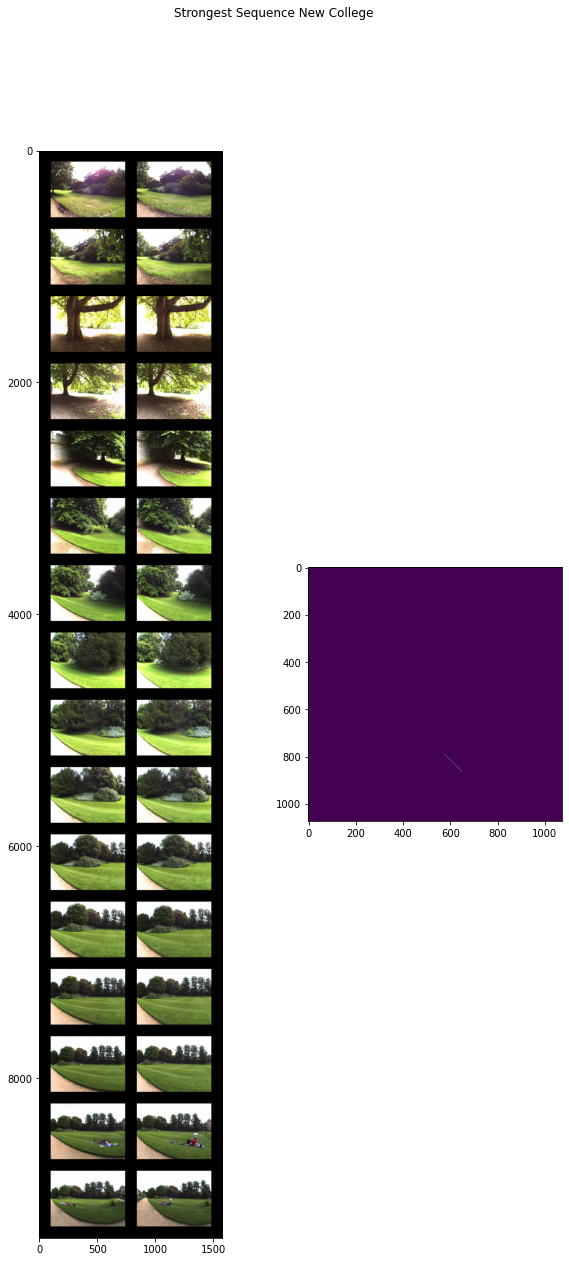

In [14]:
plot_seq(max_tracker_full, test_data, datatype, 5, (10, 20), "Strongest Sequence New College")

To compare with the RGB Stacked Denoising Auto-Encoder (SDA) designed by Gao et al.[7], we use a smaller subset of the dataset for testing. This is because the authors there also utilised such a smaller subset and therefore doing as such will ensure the comparison to be more fair (especially in the presence of approximate labelling for this data set). Graph for the SDA can be found within the report.

In [15]:
# Parameters
threshold = 50 # edge thresholding
datatype = "newcollege"
leftright = 'left' # choice of camera view
interval = 4 # interval between input test images (i.e. Interval of 2 captures all alternate left view images)
batch_size = 100
reductionvalue = 3 # rank reduction degree
img_apart = 15 # number of frames between loop closure pairs
delta = 10 # penalty for one-to-many frames
min_seq_sim = 5 # total sequence similarity threshold
min_sim = 0.24 # minimum individual similarity threshold


In [16]:
# Setting up of Test Data Set
transformations = transforms.Compose([transforms.Grayscale(),
                                      getBinEdge((256, 256), threshold),
                                      transforms.ToTensor()])
test_data = realscenes("new_college", leftright, interval, transform=transformations)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=False)
# Executing Neural Network Compression Phase
full_latent = np.empty((1, 4096), int)
full_label = []
test_loss = 0
with torch.no_grad():
    for data in test_loader:
      img, label = data
      img, label = img.to(device), list(label)
      prediction, mu, logvar, _, features = vae(img.float())
      loss = loss_func(prediction.float(), img.float(), mu, logvar, 1)
      test_loss += loss.item()
      full_latent = np.append(full_latent, features[4].view(-1, 4096).cpu(), axis=0)
      full_label.extend(label)
full_latent = np.delete(full_latent, 0, axis=0)
test_loss /= len(test_loader.dataset)
print("Average Item Loss: ", test_loss)

# Executing Loop Closure Phases
sim_matrix = calc_sim(full_latent)
rankreduced_matrix = rankreduction(sim_matrix, reductionvalue, img_apart)
smith_water_matrix, min_tracker_full, max_tracker_full = full_smith_water(rankreduced_matrix, delta, min_seq_sim, min_sim, img_apart)
final_prediction = rankreduced_matrix * smith_water_matrix

Average Item Loss:  22266.770055970148


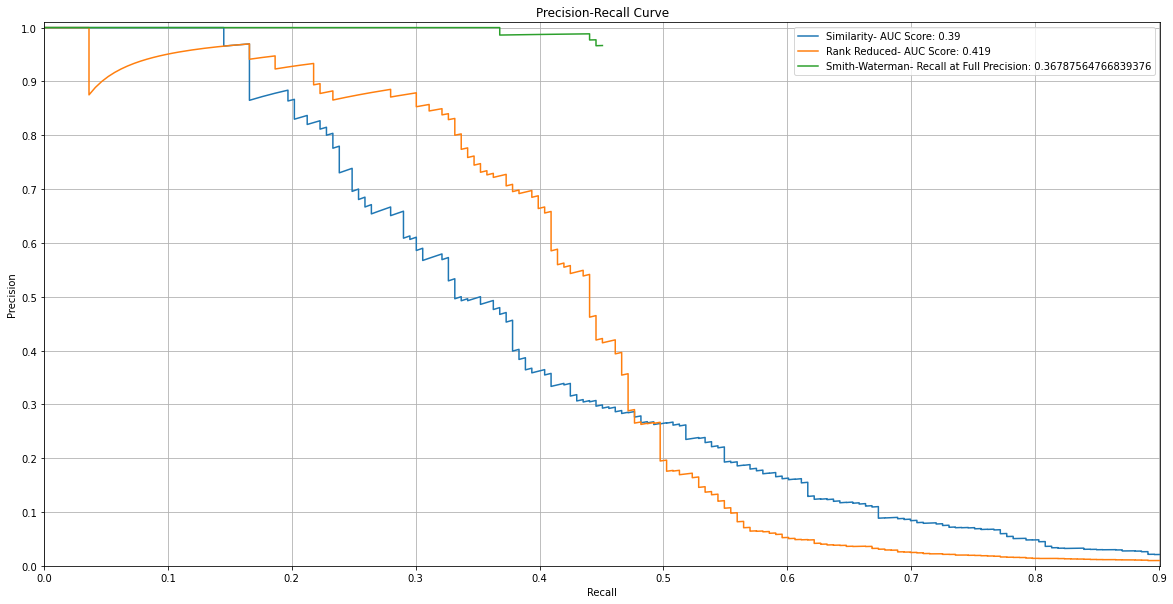

In [17]:
PRC([sim_matrix, rankreduced_matrix, final_prediction], full_label, datatype, ["Similarity", "Rank Reduced", "Smith-Waterman"], img_apart, (20, 10), 0.901, 2, 'smith')

While our algorithm, fairs well in terms of precision, it has difficulty increasing recall past a certain point. In order to visualise that, we plot some false negatives image pairs. As we can see, some of these pairs are cause by the issue of approximate/false labelling. However, the last pair elucidates the fact that coloured images are much easier to match comapred to their edge counterparts due to richer information.

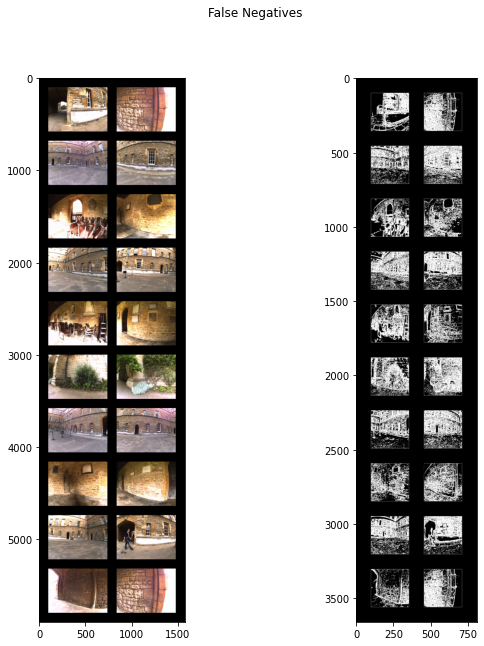

In [18]:
truth_matrix = np.genfromtxt("NewCollegeTextFormat.txt", delimiter=',', dtype=int)[:2144:interval * 2, :2144:interval * 2]
plothighestpairs(truth_matrix - rankreduced_matrix, test_data, datatype, img_apart, 10, "False Negatives", (10, 10))

###City Center Data Set
We next test on the City Center Data Set[6]. Similar to the previous dataset, this is a set of RGB images of real-life outdoor scenes. We will only use a subset of data corresponding to those taken with the right-view camera of the robot since including both left and right views simultaneously will cause a disruption when we are identifying sequences through the adjusted Smith-Waterman Algorithm.

In [19]:
# Parameters
threshold = 75 # edge thresholding
datatype = "citycenter"
leftright = 'right' # choice of camera view
interval = 1 # interval between input test images (i.e. Interval of 2 captures all alternate left view images)
batch_size = 100
reductionvalue = 8 # rank reduction degree
img_apart = 50 # number of frames between loop closure pairs
delta = 0.3 # penalty for one-to-many frames
min_seq_sim = 5 # total sequence similarity threshold
min_sim = 0.23 # minimum individual similarity threshold

In [20]:
# Setting up of Test Data Set
transformations = transforms.Compose([transforms.Grayscale(),
                                      getBinEdge((256, 256), threshold),
                                      transforms.ToTensor()])
test_data = realscenes("city_center", leftright, interval, transform=transformations)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=False)
# Executing Neural Network Compression Phase
full_latent = np.empty((1, 4096), int)
full_label = []
test_loss = 0
with torch.no_grad():
    for data in test_loader:
      img, label = data
      img, label = img.to(device), list(label)
      prediction, mu, logvar, _, features = vae(img.float())
      loss = loss_func(prediction.float(), img.float(), mu, logvar, 1)
      test_loss += loss.item()
      full_latent = np.append(full_latent, features[4].view(-1, 4096).cpu(), axis=0)
      full_label.extend(label)
full_latent = np.delete(full_latent, 0, axis=0)
test_loss /= len(test_loader.dataset)
print("Average Item Loss: ", test_loss)

# Executing Loop Closure Phases
sim_matrix = calc_sim(full_latent)
rankreduced_matrix = rankreduction(sim_matrix, reductionvalue, img_apart)
smith_water_matrix, min_tracker_full, max_tracker_full = full_smith_water(rankreduced_matrix, delta, min_seq_sim, min_sim, img_apart)
final_prediction = rankreduced_matrix * smith_water_matrix

Average Item Loss:  3150.901323767179


Plotting the same figures as in the case of New College (Matrices, Approximate Movement and Strongest Loop Sequence). As we can see, we covered most unique loop closure sequences apart from those in bottom left corner and the region in between the 2 major sequences.

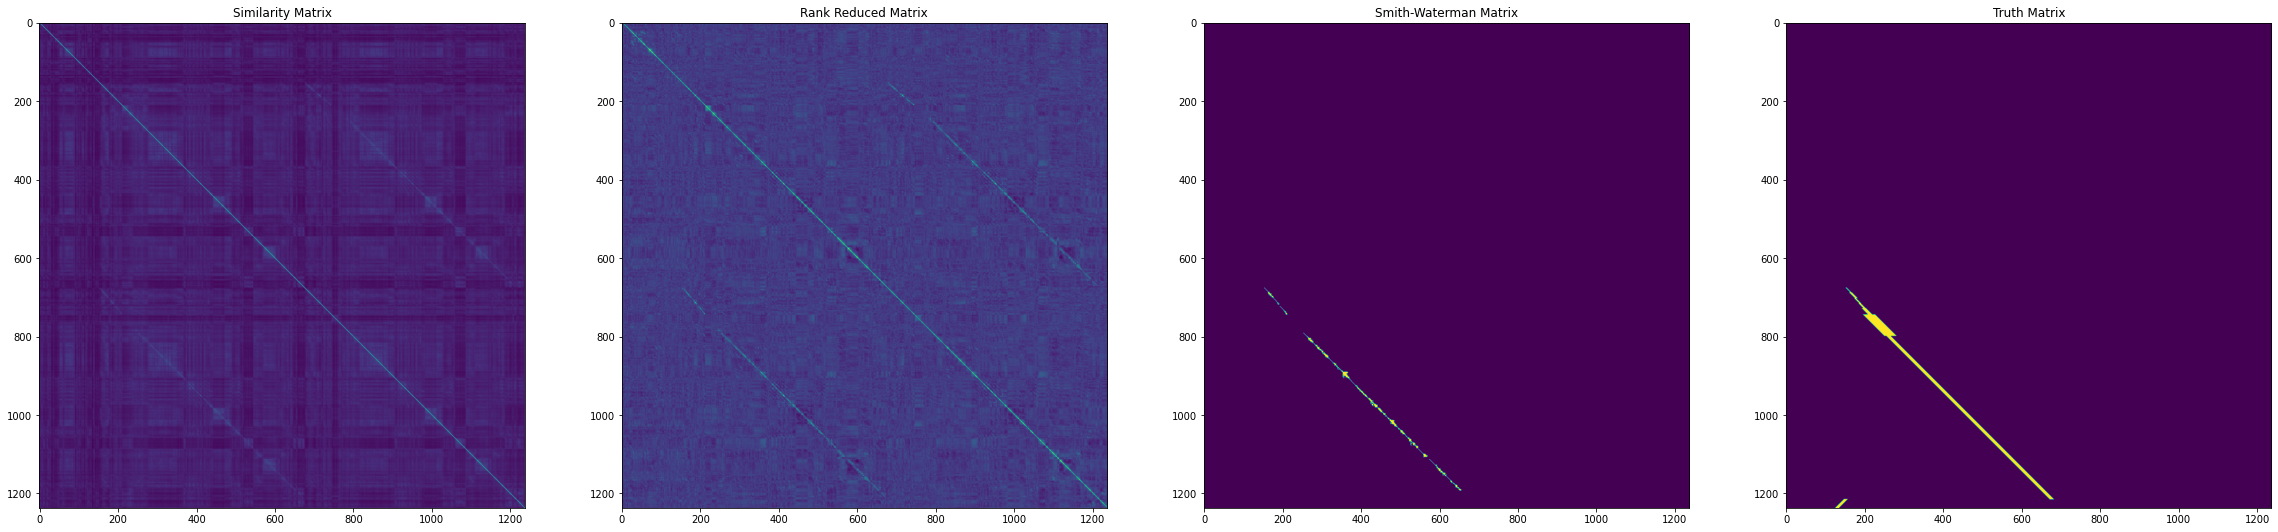

In [21]:
truth_matrix = np.genfromtxt("CityCentreTextFormat.txt", delimiter=',', dtype=int)[::interval * 2, ::interval * 2]
printmat([sim_matrix, rankreduced_matrix, smith_water_matrix, truth_matrix], ["Similarity Matrix", "Rank Reduced Matrix", "Smith-Waterman Matrix", "Truth Matrix"], (40, 10))

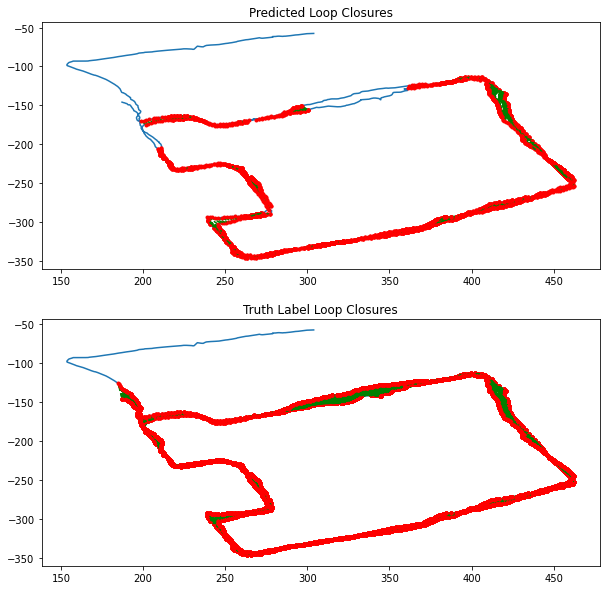

In [22]:
plotmovement(smith_water_matrix, datatype, full_label, (10, 10))

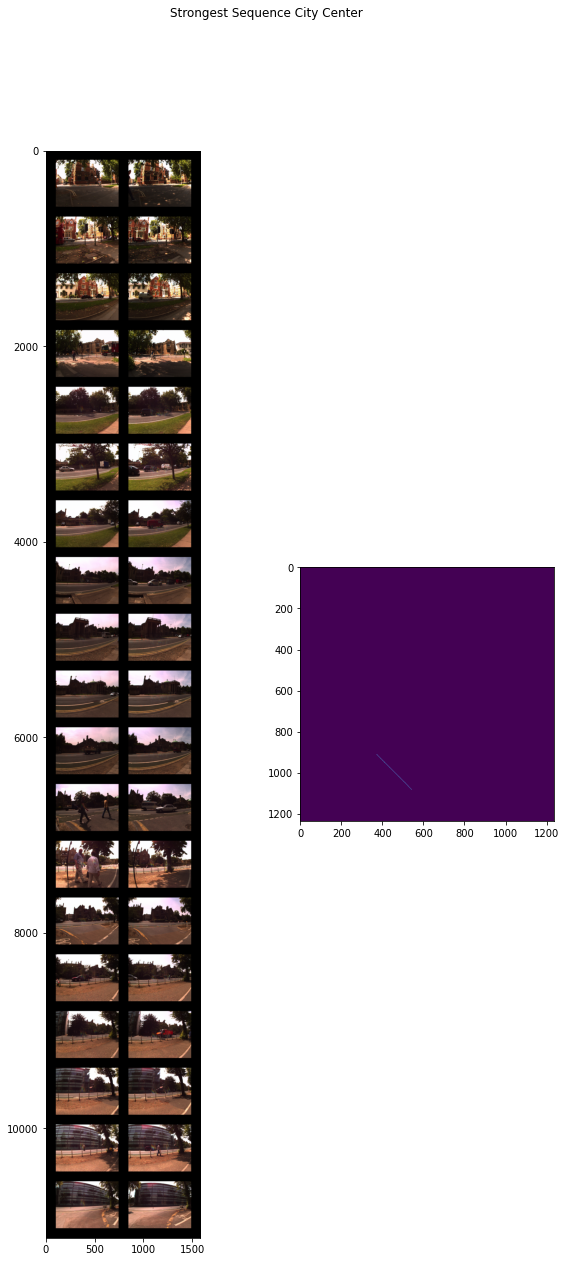

In [23]:
plot_seq(max_tracker_full, test_data, datatype, 10, (10, 20), "Strongest Sequence City Center")

To further examine the regions our algorithm was unable to uncover, we print a few image pairs from those missing regions. As we can see, most of these regions are either suffer from extreme viewpoint changes or mislabelled data due to approximation. Therefore, we conclude that we cover most of the unique loop closure sequences for the City Center data set.

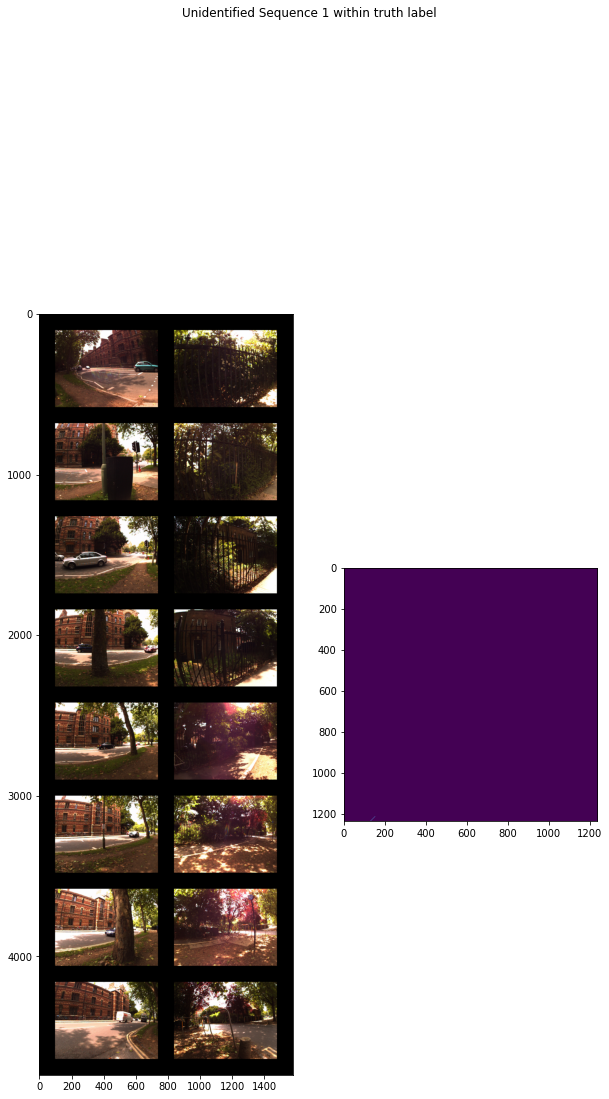

In [24]:
seq1 = np.hstack((np.expand_dims(np.arange(1236, 1213, -1), 1), np.expand_dims(np.arange(129, 152), 1)))
plot_seq(seq1, test_data, datatype, 3, (10, 20), "Unidentified Sequence 1 within truth label")

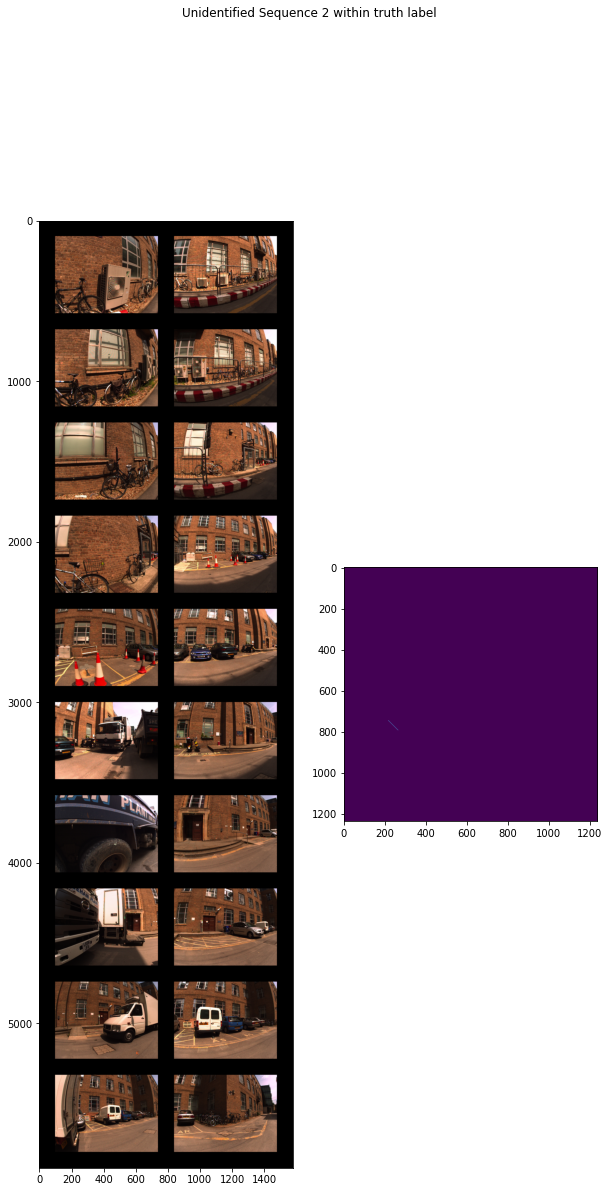

In [25]:
seq2 = np.hstack((np.expand_dims(np.arange(746, 795), 1), np.expand_dims(np.arange(215, 264), 1)))
plot_seq(seq2, test_data, datatype, 5, (10, 20), "Unidentified Sequence 2 within truth label")

Again, we plot the Precision-Recall Curve based on a subset of the images as per the experiment done by Gao et al.[7]. This time we multiply the Smith-Waterman Matrix with the Similarity Matrix to obtain the final matrix as that provides better results.

In [26]:
# Parameters
threshold = 125 # edge thresholding
datatype = "citycenter"
leftright = 'right' # choice of camera view
interval = 5 # interval between input test images (i.e. Interval of 2 captures all alternate left view images)
batch_size = 100
reductionvalue = 3 # rank reduction degree
img_apart = 50 # number of frames between loop closure pairs
delta = 10 # penalty for one-to-many frames
min_seq_sim = 30 # total sequence similarity threshold
min_sim = 0.17 # minimum individual similarity threshold

In [27]:
# Setting up of Test Data Set
transformations = transforms.Compose([transforms.Grayscale(),
                                      getBinEdge((256, 256), threshold),
                                      transforms.ToTensor()])
test_data = realscenes("city_center", leftright, interval, transform=transformations)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=False)
# Executing Neural Network Compression Phase
full_latent = np.empty((1, 4096), int)
full_label = []
test_loss = 0
with torch.no_grad():
    for data in test_loader:
      img, label = data
      img, label = img.to(device), list(label)
      prediction, mu, logvar, _, features = vae(img.float())
      loss = loss_func(prediction.float(), img.float(), mu, logvar, 1)
      test_loss += loss.item()
      full_latent = np.append(full_latent, features[4].view(-1, 4096).cpu(), axis=0)
      full_label.extend(label)
full_latent = np.delete(full_latent, 0, axis=0)
test_loss /= len(test_loader.dataset)
print("Average Item Loss: ", test_loss)

# Executing Loop Closure Phases
sim_matrix = calc_sim(full_latent)
rankreduced_matrix = rankreduction(sim_matrix, reductionvalue, img_apart)
smith_water_matrix, min_tracker_full, max_tracker_full = full_smith_water(rankreduced_matrix, delta, min_seq_sim, min_sim, img_apart)
final_prediction = sim_matrix * smith_water_matrix

Average Item Loss:  1476.0703125


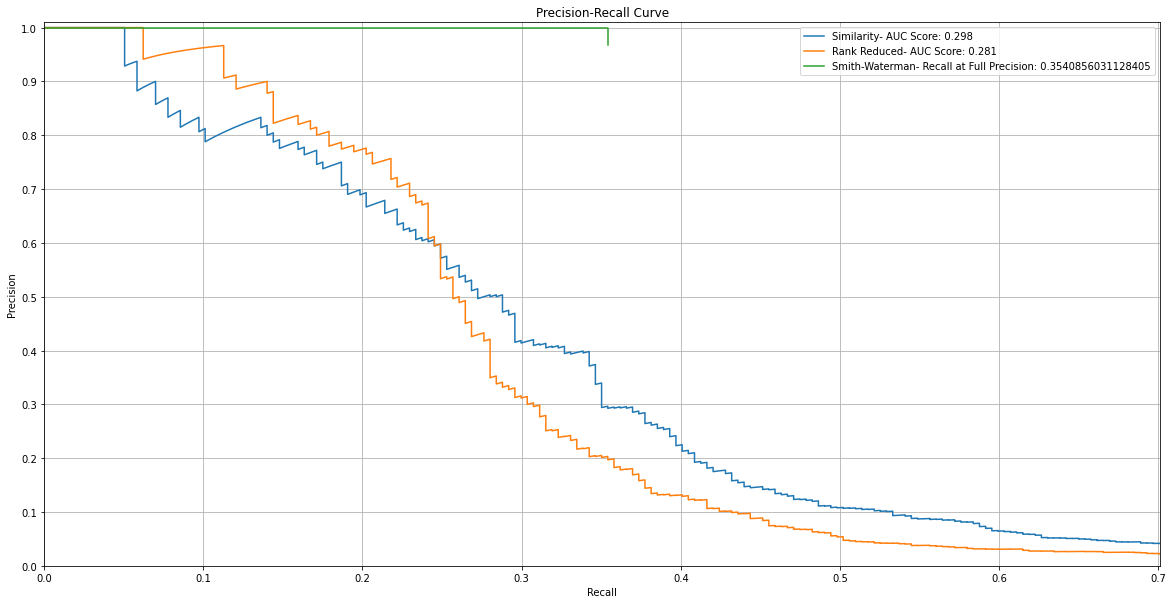

In [28]:
PRC([sim_matrix, rankreduced_matrix, final_prediction], full_label, datatype, ["Similarity", "Rank Reduced", "Smith-Waterman"], img_apart, (20, 10), 0.701, 2, 'smith')

###SCAMP-5 Data Set
We next test on a small data set of binary edge images produced by the SCAMP-5 device. This is a set of binary edge images captured within an indoor scene. The main characteristics of this data set includes the high FPS making the images relatively noisy as well as the high thresholding of these images.

In [29]:
# Parameters
datatype = "scamp"
batch_size = 100
reductionvalue = 2 # rank reduction degree
img_apart = 50 # number of frames between loop closure pairs
delta = 0.3 # penalty for one-to-many frames
min_seq_sim = 4 # total sequence similarity threshold
min_sim = 0.4 # minimum individual similarity threshold

In [30]:
# Setting up of Test Data Set
transformations = transforms.Compose([transforms.Grayscale(),
                                      transforms.ToTensor()])
test_data = scamp("edge_images_new", transform=transformations)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=False)
# Executing Neural Network Compression Phase
full_latent = np.empty((1, 4096), int)
full_label = []
test_loss = 0
with torch.no_grad():
    for data in test_loader:
      img, label = data
      img, label = img.to(device), list(label)
      prediction, mu, logvar, _, features = vae(img.float())
      loss = loss_func(prediction.float(), img.float(), mu, logvar, 1)
      test_loss += loss.item()
      full_latent = np.append(full_latent, features[4].view(-1, 4096).cpu(), axis=0)
      full_label.extend(label)
full_latent = np.delete(full_latent, 0, axis=0)
test_loss /= len(test_loader.dataset)
print("Average Item Loss: ", test_loss)

# Executing Loop Closure Phases
sim_matrix = calc_sim(full_latent)
rankreduced_matrix = rankreduction(sim_matrix, reductionvalue, img_apart)
smith_water_matrix, min_tracker_full, max_tracker_full = full_smith_water(rankreduced_matrix, delta, min_seq_sim, min_sim, img_apart)

Average Item Loss:  220.07929040055248


We print the 3 matrices at each step of the process. Since the dataset is unlabelled, a truth matrix does not exist for this dataset. Here we identified four major loop closure sequences as seen in the Smith-Waterman Matrix.

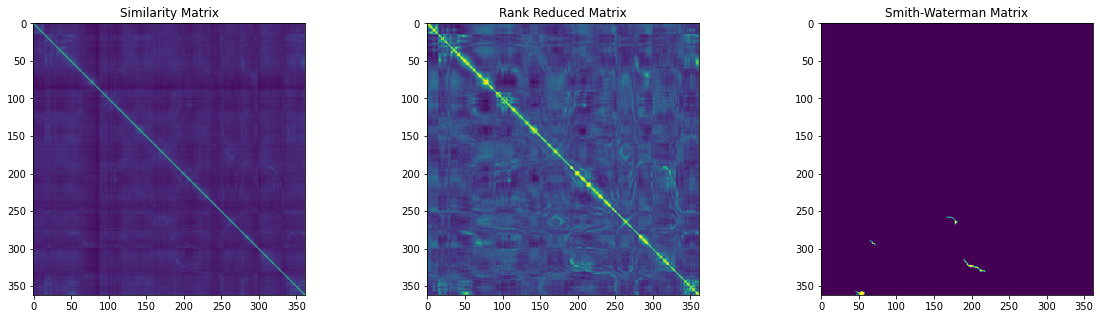

In [31]:
printmat([sim_matrix, rankreduced_matrix, smith_water_matrix], ["Similarity Matrix", "Rank Reduced Matrix", "Smith-Waterman Matrix"], (20, 5))

We print subsequences within each of this sequence to inspect if they are indeed actual loop closure sequences. As we can see, all loop closure sequences obtain were true positives.

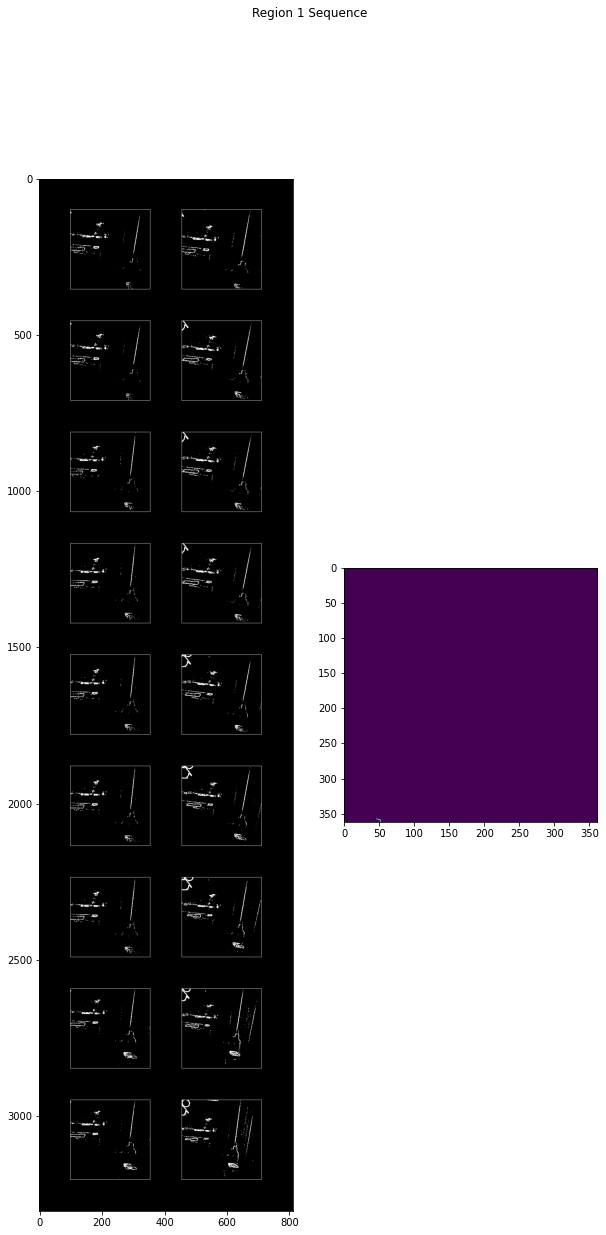

In [32]:
plot_seq(min_tracker_full, test_data, datatype, 1, (10, 20), "Region 1 Sequence")

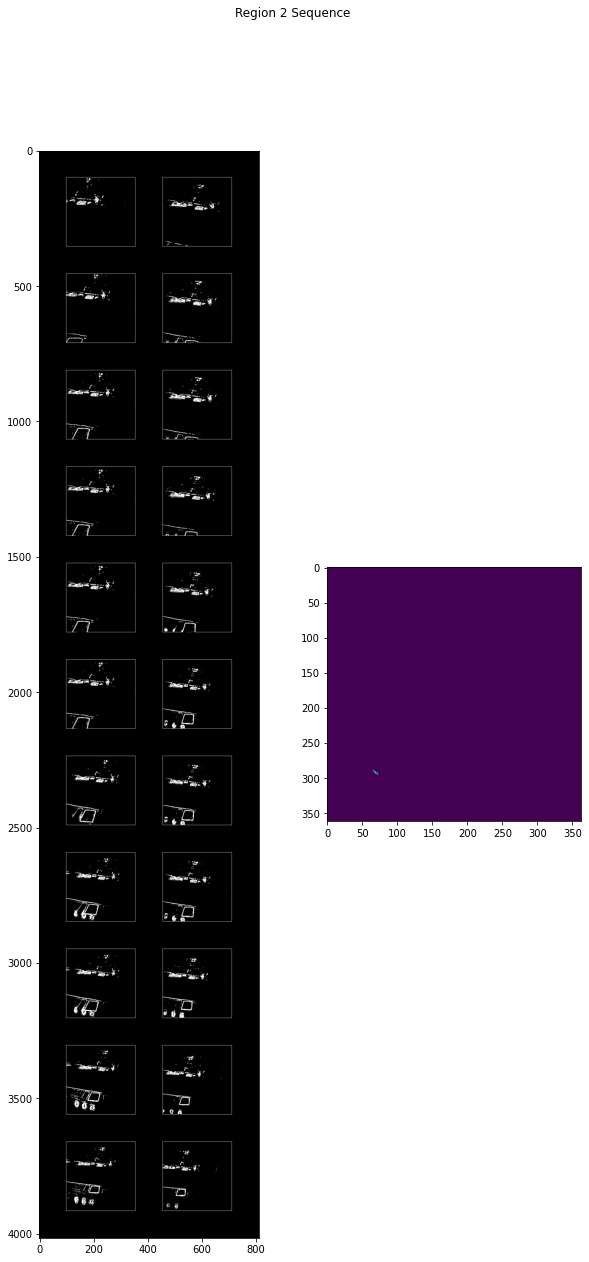

In [33]:
smith_water_matrix, min_tracker_full, _ = full_smith_water(rankreduced_matrix, delta, 4.18, min_sim, img_apart)
plot_seq(min_tracker_full, test_data, datatype, 1, (10, 20), "Region 2 Sequence")

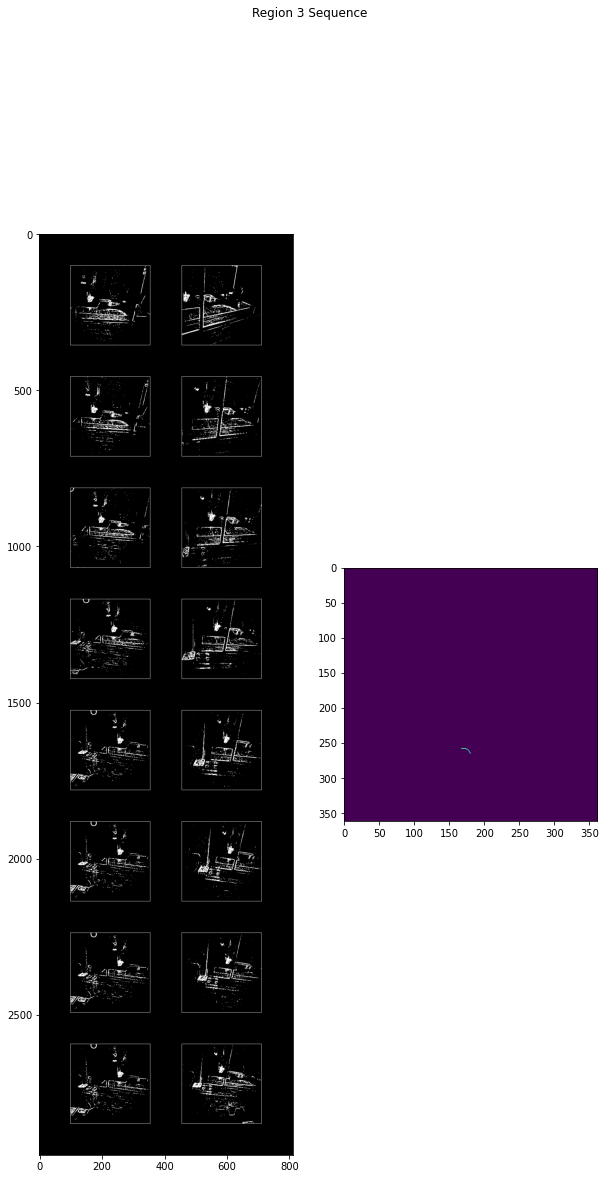

In [34]:
smith_water_matrix, min_tracker_full, _ = full_smith_water(rankreduced_matrix, delta, 5, min_sim, img_apart)
plot_seq(min_tracker_full, test_data, datatype, 2, (10, 20), "Region 3 Sequence")

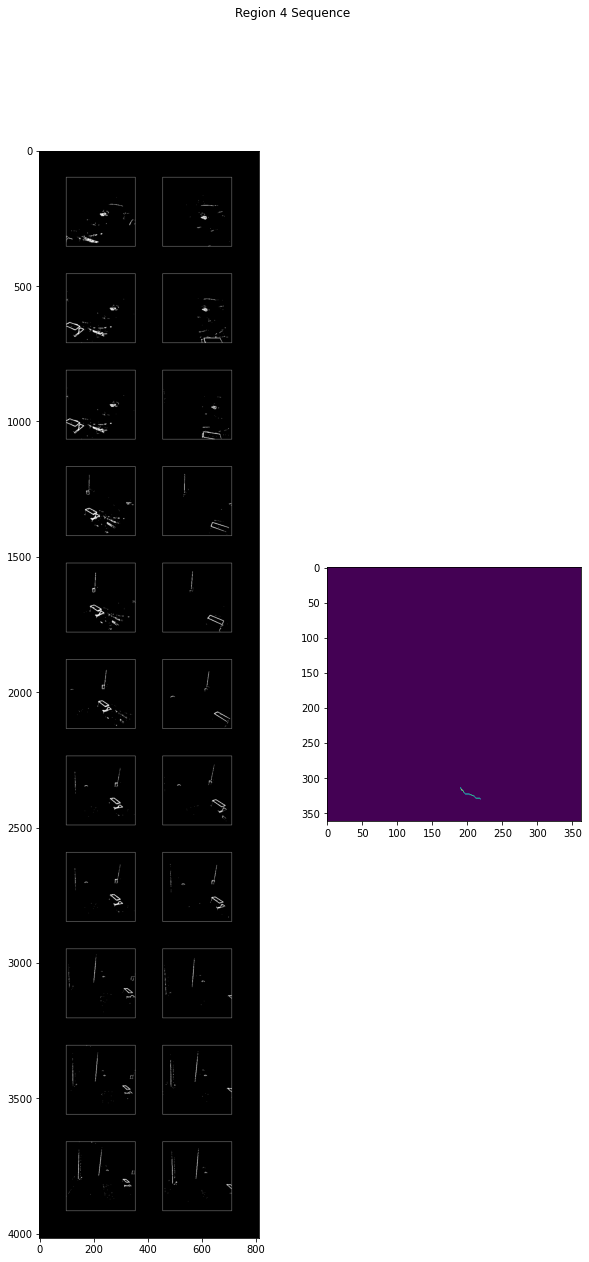

In [35]:
plot_seq(max_tracker_full, test_data, datatype, 3, (10, 20), "Region 4 Sequence")

## References
[1] R. Murai, S. Saeedi, and P. H. J. Kelly. BIT-VO: Visual Odometry at 300
FPS using Binary Features from the Focal Plane. In IEEE/RSJ International
Conference on Intelligent Robots and Systems (IROS), 2020.

[2] D. P. Kingma and M. Welling. Auto-encoding variational bayes. arXiv preprint
arXiv:1312.6114, 2013.

[3] N. Merrill and G. Huang. Lightweight unsupervised deep loop closure. arXiv
preprint arXiv:1805.07703, 2018.

[4] S. Saeedi, E. D. Carvalho, W. Li, D. Tzoumanikas, S. Leutenegger, P. H. Kelly, and A. J. Davison. Characterizing visual localization and mapping datasets. In 2019 International Conference on Robotics and Automation (ICRA), pages 6699–6705. IEEE, 2019.

[5] K. L. Ho and P. Newman. Detecting loop closure with scene sequences. International journal of computer vision, 74(3):261–286, 2007.

[6] M. Cummins and P. Newman. Fab-map: Probabilistic localization and mapping
in the space of appearance. The International Journal of Robotics Research,
27(6):647–665, 2008.

[7] X. Gao and T. Zhang. Unsupervised learning to detect loops using deep neural
networks for visual slam system. Autonomous robots, 41(1):1–18, 2017.